<a href="https://colab.research.google.com/github/akhraishasnaeencg-design/The-Enron-Email-Dataset/blob/main/The_Enron_Email_Dataset_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ===============================
# ENRON EMAILS — K-MEANS CLUSTERING
# ===============================
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Nettoyage des données...
Taille échantillon : 50000

TF-IDF transformation...

Reduction dimension...

Calcul méthode Elbow...


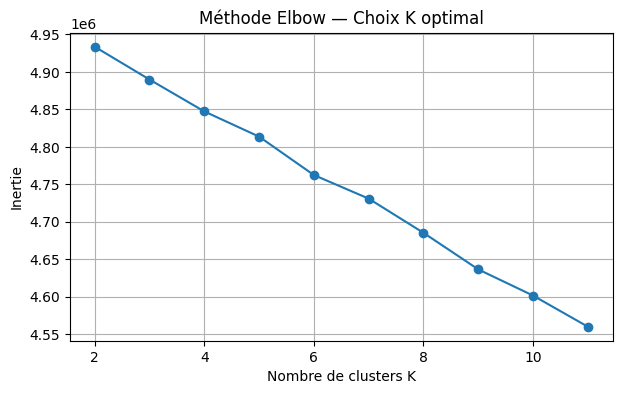


Application K-Means...
Silhouette Score : -0.02328418171172102

Visualisation PCA...


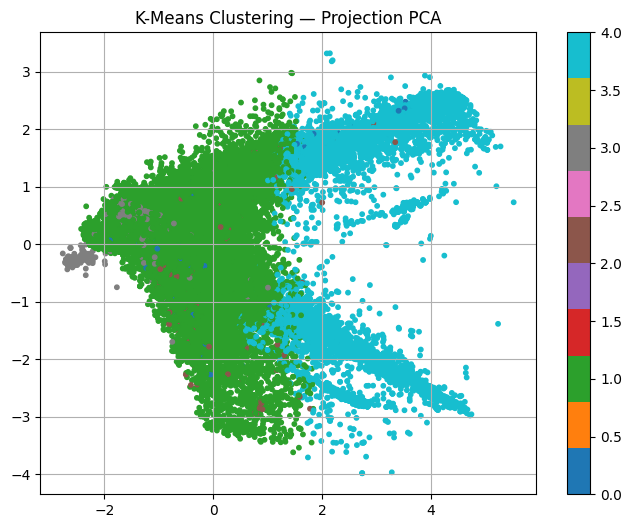

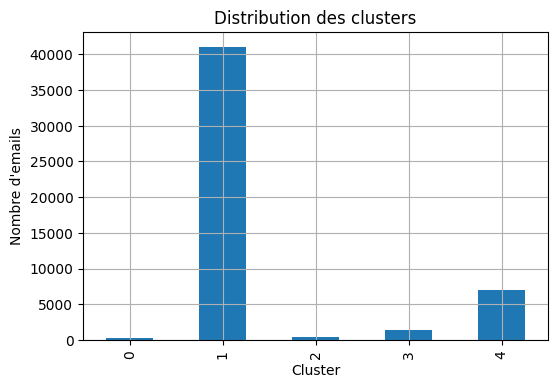


# ===============================
# RESULTATS FINAUX
# ===============================
Total emails : 50000
Silhouette Score : -0.023
Emails suspects réels : 17813
Clusters trouvés : 5


In [1]:
# =====================================================
# INSTALLATION
# =====================================================
!pip install pandas numpy scikit-learn matplotlib seaborn

# =====================================================
# IMPORTS
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("\n# ===============================")
print("# ENRON EMAILS — K-MEANS CLUSTERING")
print("# ===============================")

# =====================================================
# MONTER GOOGLE DRIVE
# =====================================================
drive.mount('/content/drive')

# =====================================================
# CHARGER DATASET ZIP
# =====================================================
zip_path = "/content/drive/MyDrive/emails.csv.zip"
extract_path = "/content/drive/MyDrive/enron_extract"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Trouver le CSV
csv_file = [f for f in os.listdir(extract_path) if f.endswith(".csv")][0]

df = pd.read_csv(os.path.join(extract_path, csv_file))

# =====================================================
# NETTOYAGE DES DONNEES
# =====================================================
print("\nNettoyage des données...")

df = df.dropna(subset=["message"])

# Échantillon représentatif (optionnel mais recommandé)
df_sample = df.sample(n=50000, random_state=42)

# Supprimer les très courts emails
df_sample = df_sample[df_sample["message"].str.len() > 20]

print("Taille échantillon :", len(df_sample))

# =====================================================
# PRETRAITEMENT — LABEL ACADEMIQUE SIMULÉ
# =====================================================
keywords = ["free", "money", "offer", "win", "cash", "urgent"]

def label_email(text):
    text = text.lower()
    return 1 if any(word in text for word in keywords) else 0

df_sample["Vrai_Label"] = df_sample["message"].apply(label_email)

# =====================================================
# TF-IDF VECTORISATION
# =====================================================
print("\nTF-IDF transformation...")

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=3000
)

X = vectorizer.fit_transform(df_sample["message"])

# =====================================================
# REDUCTION DIMENSION
# =====================================================
print("\nReduction dimension...")

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# =====================================================
# CHOIX DU K (METHODE ELBOW)
# =====================================================
print("\nCalcul méthode Elbow...")

inertia = []

K_range = range(2,12)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K_range, inertia, marker='o')
plt.title("Méthode Elbow — Choix K optimal")
plt.xlabel("Nombre de clusters K")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()

# =====================================================
# K-MEANS CLUSTERING
# =====================================================
print("\nApplication K-Means...")

k_optimal = 5   # tu peux modifier selon elbow

kmeans = KMeans(
    n_clusters=k_optimal,
    random_state=42,
    n_init=20
)

labels = kmeans.fit_predict(X_scaled)

df_sample["Cluster"] = labels

# Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print("Silhouette Score :", sil_score)

# =====================================================
# VISUALISATION PCA
# =====================================================
print("\nVisualisation PCA...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))

scatter = plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=labels,
    cmap="tab10",
    s=10
)

plt.title("K-Means Clustering — Projection PCA")
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# =====================================================
# DISTRIBUTION DES CLUSTERS
# =====================================================
plt.figure(figsize=(6,4))
df_sample["Cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'emails")
plt.grid(True)
plt.show()

# =====================================================
# RESULTATS FINAUX
# =====================================================
print("\n# ===============================")
print("# RESULTATS FINAUX")
print("# ===============================")

print("Total emails :", len(df_sample))
print("Silhouette Score :", f"{sil_score:.3f}")
print("Emails suspects réels :", df_sample["Vrai_Label"].sum())
print("Clusters trouvés :", len(set(labels)))